# Credit Card Fraud Transactions

The dataset was provided by Kaggle from the link 'https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data'. It was downloaded from there and worked localy.

Lets use some ML models to try to predict fraudulent transactions with credit card. The features from V1 to V28 are the principal components obtained from PCA and are available that way due to confidentiality issues. The other features Time and Amount were preserved. The transactions are from two consecutive days.

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, recall_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [94]:
df = pd.read_csv('creditcard.csv')

In [95]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Let's get some insights about the data

In [99]:
# Verify if there is any missing data
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [101]:
#Statistical describing
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [103]:
print("Number of transactions in the period: ", df['Amount'].count())
print(f"Highest Transaction value in the period: ${df['Amount'].max():,.2f}")
print(f"Minimum Transaction value in the period: ${df['Amount'].min():,.2f}")
print(f"Mean Transaction value in the period: ${df['Amount'].mean():,.2f}")

Number of transactions in the period:  284807
Highest Transaction value in the period: $25,691.16
Minimum Transaction value in the period: $0.00
Mean Transaction value in the period: $88.35


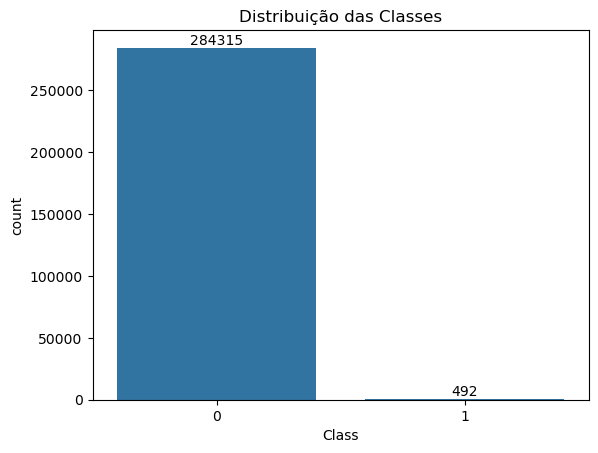

In [105]:
# Checking the distribution of the classes (fraud or no fraud)
ax = sns.countplot(x='Class', data=df)
ax.bar_label(ax.containers[0])
plt.title('Distribuição das Classes')
plt.show()

In [107]:
fraud = df[df['Class'] == 1].count()[0]
no_fraud = df[df['Class'] == 0].count()[0]

percentage = fraud/no_fraud * 100

print(f"Percentage of fraudulent transactions: {percentage:,.5f}%")

Percentage of fraudulent transactions: 0.17305%


/var/folders/qk/1hlkl_vs42x841fcykv090lw0000gn/T/ipykernel_6663/3996048967.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fraud = df[df['Class'] == 1].count()[0]
/var/folders/qk/1hlkl_vs42x841fcykv090lw0000gn/T/ipykernel_6663/3996048967.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_fraud = df[df['Class'] == 0].count()[0]


The dataset is really unbaleced. We can see that the number of fraudulent transactions correspond to 492 transactions, wich represent 0.1730% of the data. This shows that it is necessary to use approaches to identify the outliers. Personally, I do not think that create 'fake' data to rebalance the data is not so good. Let's continue with the analysis.

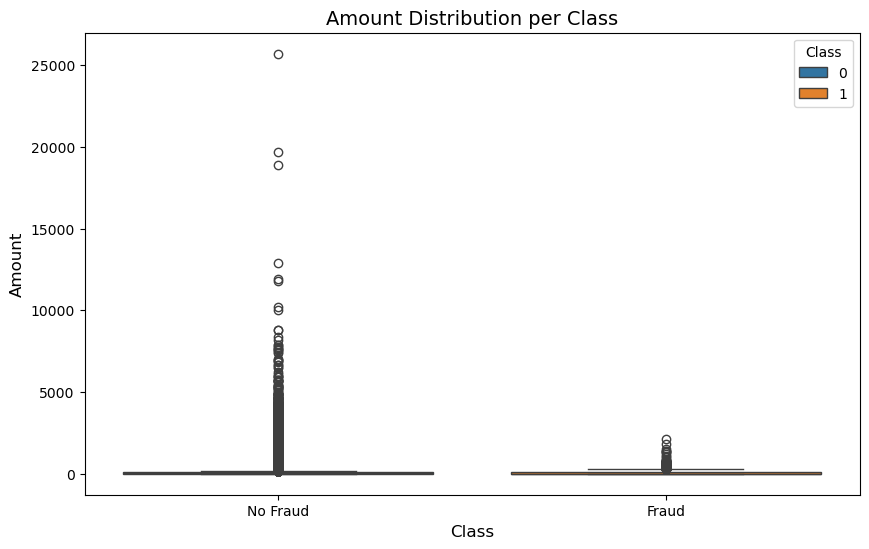

In [110]:
# Creating a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df, hue='Class')
plt.title('Amount Distribution per Class', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Fraud', 'Fraud'])
plt.show()


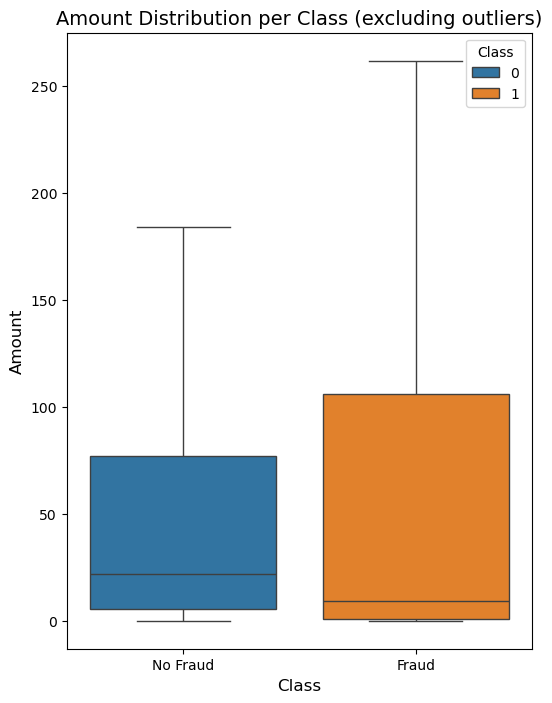

In [112]:
#Excluding the outliers
plt.figure(figsize=(6, 8))
sns.boxplot(x='Class', y='Amount', data=df, hue='Class', showfliers=False)
plt.title('Amount Distribution per Class (excluding outliers)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Fraud', 'Fraud'])
plt.show()

In [114]:
no_fraud = df.loc[df['Class'] == 0]['Amount']
fraud = df.loc[df['Class'] == 1]['Amount']

In [116]:
no_fraud.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [118]:
fraud.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

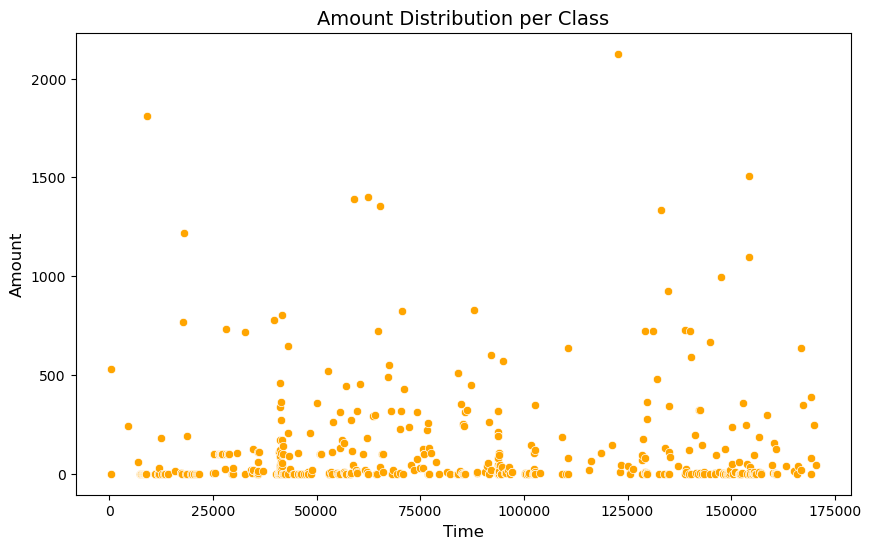

In [120]:
fraudulent = df.loc[df['Class'] == 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fraudulent['Time'], y=fraudulent['Amount'], color='orange')
plt.title('Amount Distribution per Class', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.show()

/var/folders/qk/1hlkl_vs42x841fcykv090lw0000gn/T/ipykernel_6663/4139487453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudulent['Hour'] = fraudulent['Time'].apply(lambda x: np.floor(x / 3600))


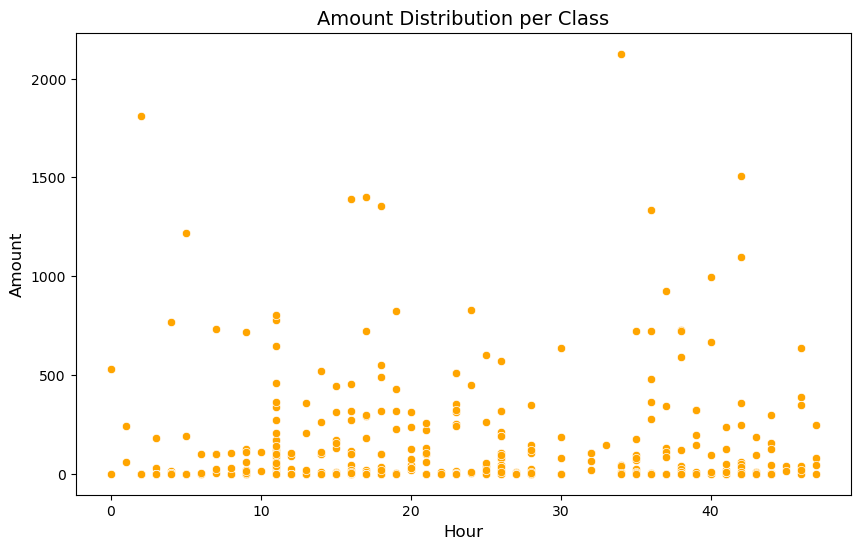

In [122]:
# Creating the hourly column
fraudulent['Hour'] = fraudulent['Time'].apply(lambda x: np.floor(x / 3600))

#Ploting fraudulent transactions over the hours
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fraudulent['Hour'], y=fraudulent['Amount'], color='orange')
plt.title('Amount Distribution per Class', fontsize=14)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.show()

In [124]:
fraudulent.loc[fraudulent['Amount'] == 0.00].count()[0]

/var/folders/qk/1hlkl_vs42x841fcykv090lw0000gn/T/ipykernel_6663/343923070.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fraudulent.loc[fraudulent['Amount'] == 0.00].count()[0]


27

With the scatter plot above we can see some strange fact that is fraudulent transactions which have the amount of zero. That corresponds to 27 transactions. It is possible due to credit card verification online transactions.

# Feature analysis

Let's now analyse feature correlation.

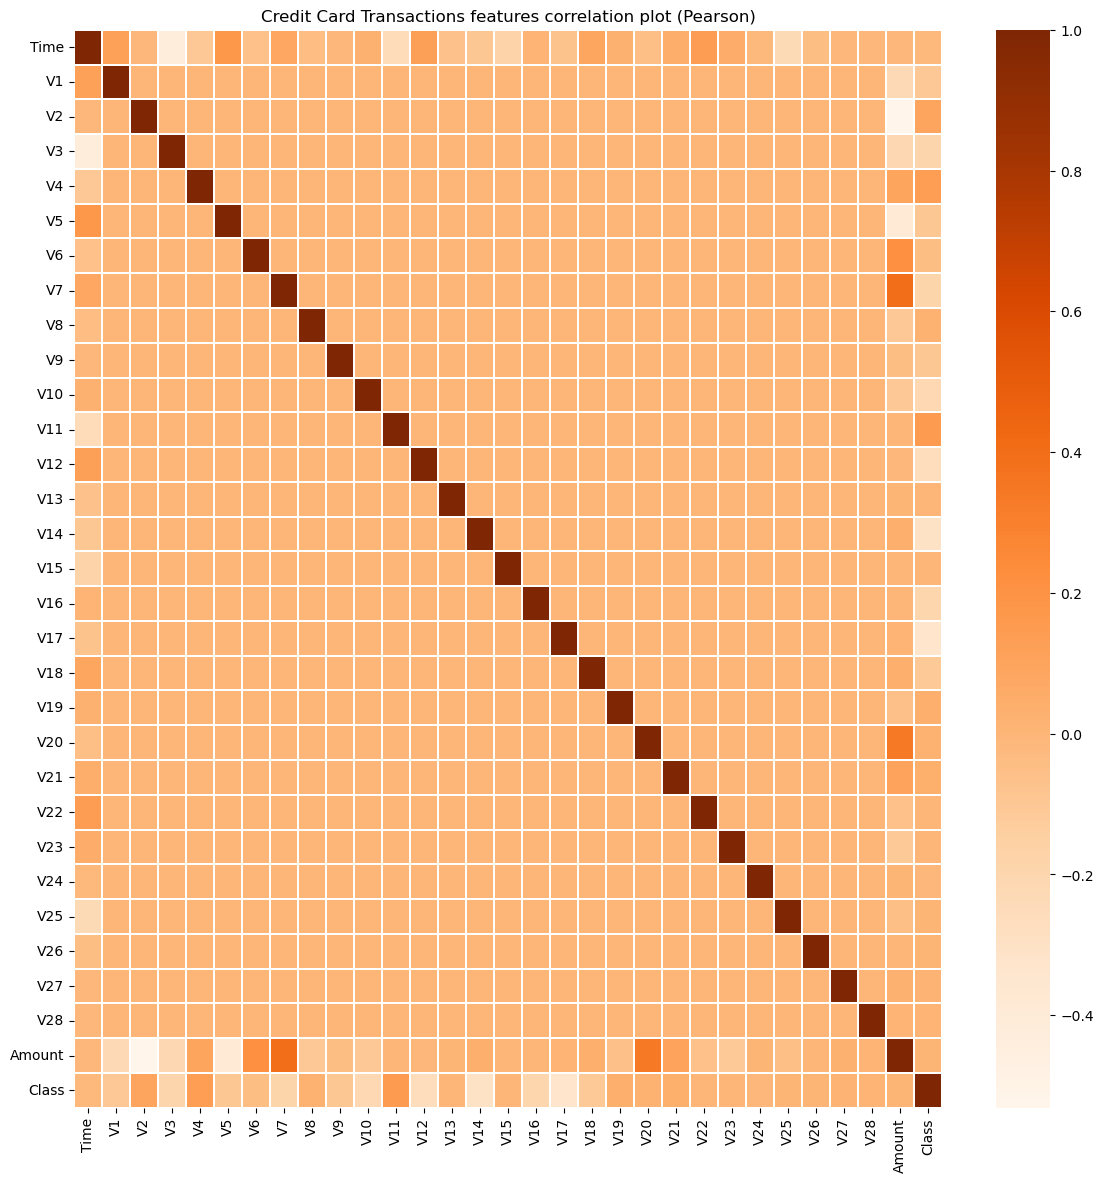

In [129]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Oranges")
plt.show()

Looks like there is no notable correlation between the features V1 to V28. There is only some correlations between the features, Amount and Time.

# Training the model

The models we are goingo to train are XGBoost and LightGBM to compare the performance.

In [134]:
# Dropping the column Time that is not necessary
df = df.drop(columns = ['Time'], axis = 1)

In [136]:
X = df.drop(columns=['Class'], axis=1)
y = df.Class

train_x, test_x, train_y,test_y = train_test_split(X, y, test_size= 0.3, random_state = 42, shuffle = True)

First, let's do some scaling to the data, in order to avoid bias in the modelo. The transaction values are in diferent scale from the features V1 to V28 and we don't want the model to give different weights to that feature.

One important note is that we are using hte Standard Scaler and fitting only in the train data to avoid data leakage and to keep the test data "untouched".

In [139]:
scaler = StandardScaler()

train_x['Amount'] = scaler.fit_transform(train_x[['Amount']])
test_x['Amount'] = scaler.transform(test_x[['Amount']])

In [141]:
train_x[['Amount']].head()

,Amount
2557,-0.339748
247823,4.277740
152342,-0.053399
103385,-0.335956
8771,-0.199244


In [143]:
test_x[['Amount']].head()

,Amount
43428,1.065644
49906,1.669027
29474,-0.223661
276481,-0.337813
278846,-0.340173


## XGBoost Classifier

Since we have a huge unscalled dataset, let's use some strategies besides creating fake data. Let's try penalizing errors on the minority class (fraudulent transactions).

In [147]:
scale_pos_weight = len(no_fraud) / len(fraud)

In [149]:
model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.041,
    early_stopping_rounds=50,
    max_depth=7,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.9,
    min_child_weight=2,
    eval_metric='auc',
    random_state=42
)

model.fit(train_x, train_y, eval_set=[(test_x, test_y)])

[0]	validation_0-auc:0.97126
[1]	validation_0-auc:0.96935
[2]	validation_0-auc:0.95076
[3]	validation_0-auc:0.94965
[4]	validation_0-auc:0.96547
[5]	validation_0-auc:0.97055
[6]	validation_0-auc:0.96958
[7]	validation_0-auc:0.98269
[8]	validation_0-auc:0.98371
[9]	validation_0-auc:0.98389
[10]	validation_0-auc:0.98352
[11]	validation_0-auc:0.98306
[12]	validation_0-auc:0.98283
[13]	validation_0-auc:0.98219
[14]	validation_0-auc:0.98128
[15]	validation_0-auc:0.98129
[16]	validation_0-auc:0.98113
[17]	validation_0-auc:0.98045
[18]	validation_0-auc:0.98039
[19]	validation_0-auc:0.97997
[20]	validation_0-auc:0.97942
[21]	validation_0-auc:0.97915
[22]	validation_0-auc:0.97903
[23]	validation_0-auc:0.97799
[24]	validation_0-auc:0.97772
[25]	validation_0-auc:0.97719
[26]	validation_0-auc:0.97743
[27]	validation_0-auc:0.97724
[28]	validation_0-auc:0.97707
[29]	validation_0-auc:0.97606
[30]	validation_0-auc:0.97611
[31]	validation_0-auc:0.98079
[32]	validation_0-auc:0.98060
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.041, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

<Figure size 1000x600 with 0 Axes>

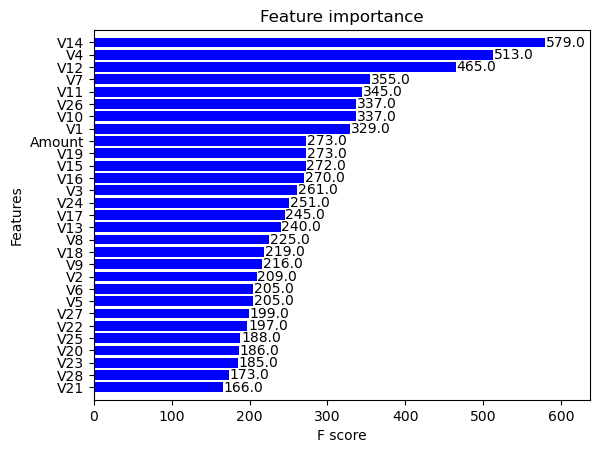

In [150]:
plt.figure(figsize=(10, 6))
ax = xgb.plot_importance(model, height=0.8, color="blue") 
ax.grid(False)
plt.show()

In [153]:
xgb_prediction = model.predict(test_x)

In [155]:
auc_score = roc_auc_score(test_y.values, xgb_prediction)
print("The AUC score for the prediction of test set is ",auc_score )

The AUC score for the prediction of test set is  0.9445305760716141


In [157]:
xgb_recall = recall_score(test_y.values, xgb_prediction)

print("The recall score for the prediction of test set is ", xgb_recall)

The recall score for the prediction of test set is  0.8897058823529411


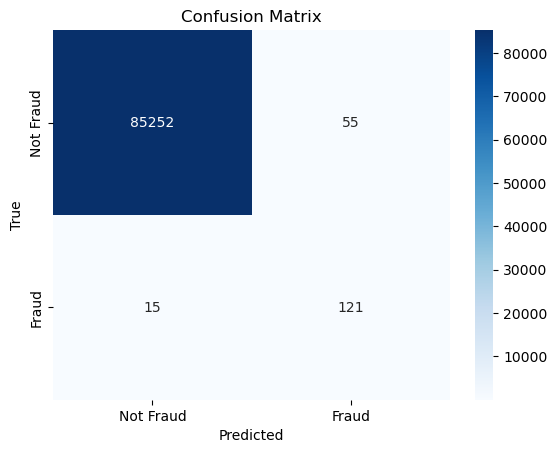

In [159]:
cm = confusion_matrix(test_y, xgb_prediction)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

We can see from the confusion matrix that the model identified 15 fraudulent cases as not fraud. Also, identified as Fraud 55 cases which are not. Meanwhile, we've got a recall score of 88.97%, which is a good value.

## LGBM Model

In [163]:
model_lgbm = LGBMClassifier(
    objective='binary',
    scale_pos_weight=scale_pos_weight,
    n_estimators=500,
    early_stopping_rounds=50,
    learning_rate=0.046,
    subsample=0.8,
    colsample_bytree=0.9,
    min_child_weight=2,
    max_depth=7,
    random_state=42
)
model_lgbm.fit(train_x, train_y, eval_set=[(test_x, test_y)])

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 356, number of negative: 199008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001786 -> initscore=-6.326170
[LightGBM] [Info] Start training from score -6.326170
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=50,
               learning_rate=0.046, max_depth=7, min_child_weight=2,
               n_estimators=500, objective='binary', random_state=42,
               scale_pos_weight=577.8760162601626, subsample=0.8)

<Figure size 1000x600 with 0 Axes>

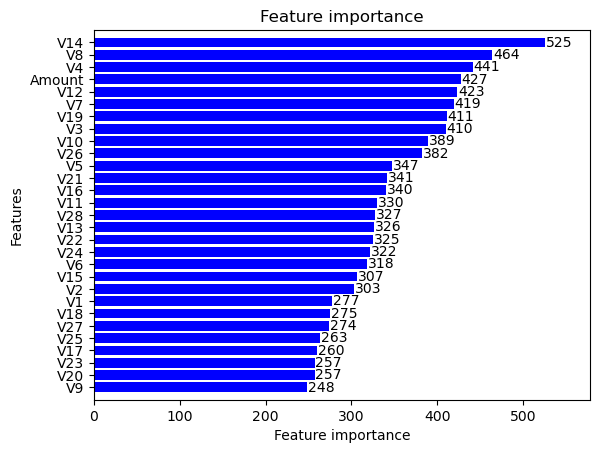

In [165]:
plt.figure(figsize=(10, 6))
ax = lgb.plot_importance(model_lgbm, height=0.8, color="blue") 
ax.grid(False)
plt.show()

In [167]:
lgbm_prediction = model_lgbm.predict(test_x)

In [169]:
auc_score_lgbm = roc_auc_score(test_y.values, lgbm_prediction)
print("The AUC score for the prediction of test set is ",auc_score_lgbm)

The AUC score for the prediction of test set is  0.9262713079886555


In [171]:
lgbm_recall = recall_score(test_y.values, lgbm_prediction)

print("The recall score for the prediction of test set is ", lgbm_recall)

The recall score for the prediction of test set is  0.8529411764705882


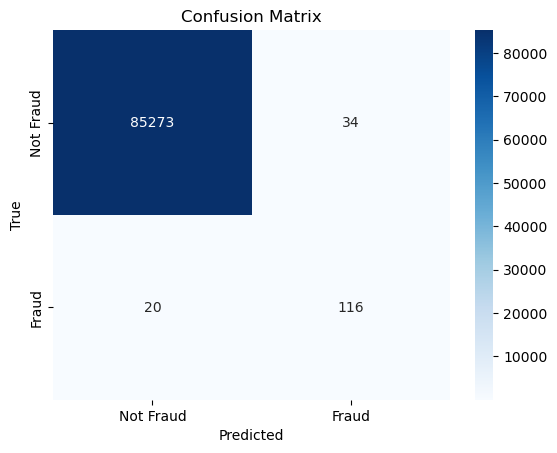

In [173]:
cm_lgbm = confusion_matrix(test_y, lgbm_prediction)

sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

We can see some insights from both models above. It is good to pint out that a better optimization of the parameters can be running with Randonmized Search or Grid Serach CV algorithms to extract some better performance.

From the Confusion Matrix it is possible to see that:

- XGBoost could identify 121 fraudulent cases, meanwhile LightGBM indentify 116 (5 cases less).
- LGBM also predicted as "Not Fraud" 20 cases, while XGB missed only 15. That is an important aspect, because we need besides optmize identifying fraudulent transactions, it is also importante to reduce the error on passing frauds as normal transactions.
- Another interesting aspect is that LGBM had a better performance on predicting as "Fraud" normal transactions (34 cases), while XGB had a larger number of 55. Although this, on my point of view is less harmful to the business.
- On performance scores (ROC/AUC and RECALL), XGB overperformed LGBM.